## Question 1: Do books available via subscription services and bundles achieve higher visibility? And does a higher price leads to lower engagement? What is the best price

**Approach:**

We set price equal NA are -2 and 0s are -1 for binning easier. The quantiles, min, max are used for establishing ranges

1. **Group Definitions:**
    * *group_bundl:* Ratings for the "Bundle" group (where price is -2)
    * *group_sub:* Ratings for the "Subscription" group (where price is -1)
    * *group_traditional:* Ratings for the "Traditional" group (where price is positive)

2. **Kruskal-Wallis Test:**
    * The Kruskal-Wallis H-test is performed to evaluate whether there are statistically significant differences in the median ratings across the three groups
    * If the p-value is greater than or equal to the alpha, it concludes that there is no statistically significant difference among the groups (fails to reject the null hypothesis)
    * Otherwise, it concludes that a significant difference exists (rejects the null hypothesis) and performs pairwise comparisons

3. **Pairwise Comparisons:**

    * If differences are found, pairwise comparisons using the Mann-Whitney U test are conducted between: *Subscription vs. Traditional*, *Bundle vs. Traditional* and *Bundle vs. Subscription*. Each pairwise comparison prints its respective p-value (the Mann-Whitney U test suitale with small sample sizes and the data does not follow a normal distribution)
    * From here we can determine the best choice by comparing the p-values of the three pairs

4. **Pricing:**

    * A box plot visualizes the distribution of user ratings based on categorized pricing strategies to check if higher price leads to lower engagement
    * Compare user ratings between two specific groups of pricing strategies (the best price from the visualization and the rest of traditional pricing) to tell the author which price is the best option

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress = True, linewidth = 120, edgeitems = 5)
sns.set_theme(style="whitegrid")

In [2]:
# 1. Load data and view structure

dataPath = "../../Data/Raw/parsed_books_data.tsv"

df = pd.read_csv(dataPath, sep = "\t", na_values = ["NA"])

sampleCount, featureCount = df.shape

In [3]:
df["price"].describe()

count    3252.000000
mean        9.616307
std         5.002347
min         0.000000
25%         6.990000
50%         9.990000
75%        12.990000
max        36.480000
Name: price, dtype: float64

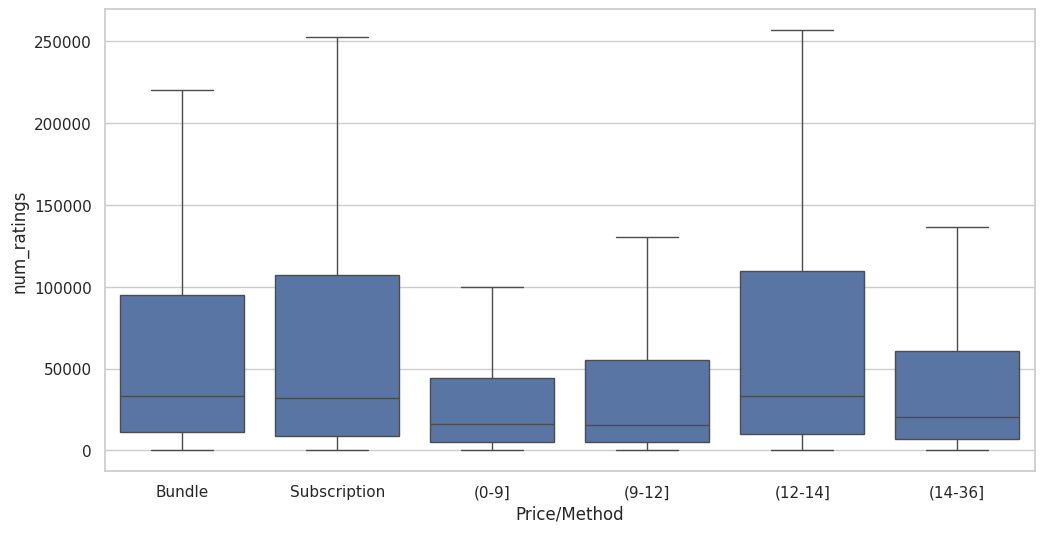

In [4]:
df.loc[df["price"] == 0, "price"] = -1
df.loc[df["price"].isna(), "price"] = -2

bins = [-3, -2, 0, 9, 12, 14, 36]
df["binned"] = pd.cut(df["price"], bins)

plt.figure(figsize=(12, 6))

ax = sns.boxplot(
    x=df["binned"], 
    y=df["num_ratings"], 
    data=df.groupby("binned", observed=True)["num_ratings"].apply(pd.DataFrame),
    showfliers=False
)
ax.set_xticks(range(6))
ax.set_xticklabels(["Bundle", "Subscription", "(0-9]", "(9-12]", "(12-14]", "(14-36]"])
ax.set_xlabel("Price/Method")

plt.show()

### 1. Do books available via subscription services and bundles achieve higher visibility?

In [5]:
from scipy import stats

alpha = 0.05

# Note: NA (-2) = Bundle, 0 (-1) = Subscription
group_bundle = df[df["price"] == -2]["num_ratings"]
group_sub = df[df["price"] == -1]["num_ratings"]
group_traditional = df[df["price"] > 0]["num_ratings"]

h_stat1, p_val1 = stats.kruskal(group_bundle, group_sub, group_traditional)
print(f"Kruskal-Wallis p-value: {p_val1:.4e}")

if p_val1 >= alpha:
    print("There is no statistically significant difference in the median time on page among the three groups (fail to reject the null hypothesis)")
else:
    print("There is statistically significant difference in the median time on page among the three groups (reject the null hypothesis)")

    _, p1 = stats.mannwhitneyu(group_sub, group_traditional, alternative='greater')
    print(f"Subscription vs. Traditional p-value: p1 = {p1:.4e}")
    _, p2 = stats.mannwhitneyu(group_bundle, group_traditional, alternative='greater')
    print(f"Bundle vs. Traditional p-value: p2 = {p2:.4e}")
    _, p3 = stats.mannwhitneyu(group_bundle, group_sub)
    print(f"Bundle vs. Subscription p-value: p3 = {p3:.4e}")

Kruskal-Wallis p-value: 7.3805e-25
There is statistically significant difference in the median time on page among the three groups (reject the null hypothesis)
Subscription vs. Traditional p-value: p1 = 2.1674e-07
Bundle vs. Traditional p-value: p2 = 1.0126e-24
Bundle vs. Subscription p-value: p3 = 7.1787e-01


From the result, both $p_1$ and $p_2$ are smaller than $\alpha = 0.05$ implies **Bundle and Subscription groups are better choices**

But $p_3 > \alpha$ so we don't know which one is better. We can look at the percentage of author of each option as another factor

In [6]:
df_na = df[df["price"] == -2]
df_0 = df[df["price"] == -1]

print("The percentage of authors choose Bundle option: ", end="")
print(f"{np.round(df_na["author"].unique().size*100/df["author"].unique().size, decimals=2)}% (total {df_na["author"].unique().size})")

print("The percentage of authors choose Subscription option: ", end="")
print(f"{np.round(df_0["author"].unique().size*100/df["author"].unique().size, decimals=2)}% (total {df_0["author"].unique().size})")

The percentage of authors choose Bundle option: 31.81% (total 988)
The percentage of authors choose Subscription option: 11.62% (total 361)


There is ~31% of authors who have successfully books chose Bundle option, higher than the Subscription one

#### Conclustion:

* The author should consider choose the Bundle option to achieve higher visibility 

### 2. Does a higher price leads to lower engagement? What is the best price?

#### Observation:
* From the visualization, the number of ratings (the quantiles, min, max,...) increases from bin (0, 9] to bin (12, 14] and then drops when the prices are in the range of 14-36$

#### Conclusion:
* This variability could imply that while some users may be satisfied at higher prices, many others are not, leading to overall lower engagement.

Now, we will find the best price. The 12-14$ bin is promising. We will check if this range is the best option if authors choose the traditional route when releasing their books.

In [7]:
group_12_14 = df[(df["price"] > 12) & (df["price"] <= 14)]["num_ratings"]
group_rest_trad = df[(df["price"] > 0) & ((df["price"] <= 12) | (df["price"] > 14))]["num_ratings"]

_, p_val = stats.mannwhitneyu(group_12_14, group_rest_trad, alternative='greater')
print(f"12-14$ vs. the rest: p-value = {p_val:.4e}")

12-14$ vs. the rest: p-value = 8.2755e-19


The p-value $< \alpha$, indicating that the hypothesis is true, the 12-14$ bin is the better than the rest ones

#### Conclusion

* The author should consider pricing their book between 12-14$. This price range is likely to attract a broader audience while also promising improved income potential.